#### Coin Toss Description

Let's toss a coin n times and have it come up with x successes.  What's the true success rate?

We'll have a random variable X which returns [0,1].  Success = 1.    

How do we model the probabiility distribution of values of possible values for p(X=1)

Note you have a probability distribution for values of a possible probability.

#### pymc3

In [23]:

import pymc3 as pm
import theano
import numpy as np

from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


In [1]:


data = [1,1,1,0,0,0,0,0,0,0]

with pm.Model() as m:
    theta = pm.Beta('theta', 2,2) #prior
    observed = pm.Bernoulli('bern', theta, observed=data) #likelihood
    

/Users/larsonte/anaconda3/envs/keras2/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [2]:
with m:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 10000/10000 [00:01<00:00, 5285.29it/s]


In [5]:
theta_samp = trace['theta']  #posterior distribution of Bernoulli model parameter. 

#note that the observed stochastic variable doesn't have an associated trace.  
#in this case you find the posterior of the model parameter which is "theta" in trace.  

In [27]:
trace.varnames

['beta_logodds_', 'beta']

In [50]:
with m:
    map_estimate = pm.find_MAP()


Optimization terminated successfully.
         Current function value: 7.332832
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


In [51]:
map_estimate

{'beta_logodds_': array(-0.5877866686429116)}

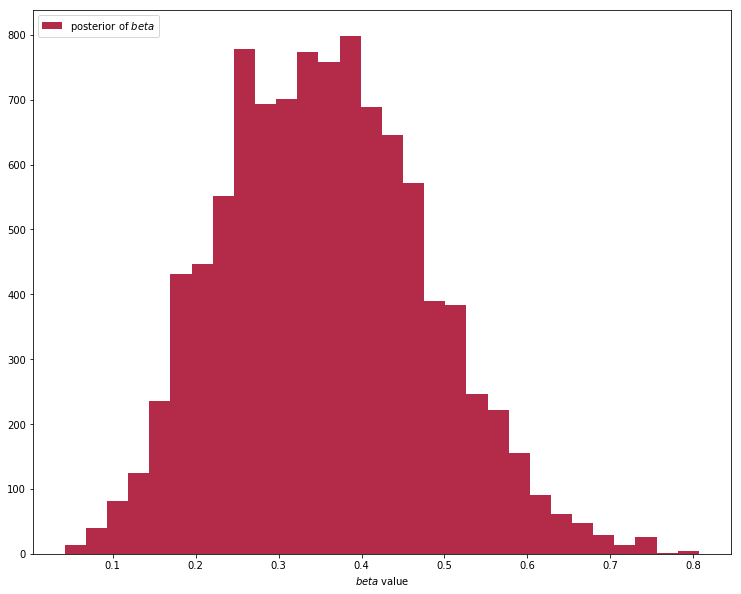

In [19]:
figsize(12.5, 10)
#histogram of the samples:

ax.set_autoscaley_on(False)

plt.hist(theta_samp, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of model parameter $theta$", color="#A60628")
plt.legend(loc="upper left")
plt.xlabel("$theta$ value")


In [11]:
theta_samp.shape

(10000,)

In [12]:
np.max(theta_samp)

0.8068242008603731

In [28]:
#### Edward

In [1]:
from edward.models import Bernoulli, Beta, Uniform
import tensorflow as tf
import edward as ed

In [10]:
#not sure I named everything correctly below.  

data = [1,1,1,0,0,0,0,0,0,0]

prior = Uniform(low=0., high=1.) #could also be a Beta.
post  = Bernoulli(prior,  sample_shape=10) #posterior or likelihood? 

#variational approximation
# no clue how we know this should be a beta.  Is guessing this part of inference or are we picking a known conjugate distribution?
a = tf.nn.softplus(tf.Variable(tf.random_normal([])))
b = tf.nn.softplus(tf.Variable(tf.random_normal([])))
q_p = Beta(a,b)


In [14]:
#Does data go with the posterior?
inference = ed.KLqp({prior: q_p}, {post: data})
#inference = ed.KLqp({post: q_p}, {prior: data}) #this throws an error about variable shapes.  Must be wrong. 


#http://edwardlib.org/api/inference-classes - see exact inference section. 
#post = ed.complete_conditional(prior)


In [15]:
inference.run(n_iter=1500, n_samples=30)

1500/1500 [100%] ██████████████████████████████ Elapsed: 29s | Loss: 8.002


In [16]:
sess = ed.get_session()
mean, stddev = sess.run([q_p.mean(), q_p.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev:")
print(stddev)

Inferred posterior mean:
0.293839
Inferred posterior stddev:
0.216362


In [31]:
#can only do this after inference? 
samples = q_p.sample(300).eval()


In [32]:
np.mean(samples)

0.30177987